In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
Device : cuda:1
Number of actions : 4


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 50000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.
class StateHolder:
    def __init__(self):
        state = get_screen()
        self.states = torch.cat((state, state, state, state))
    def push(self, screen):
        self.states = torch.cat((self.states[1:], screen))
    def reset(self):
        state = get_screen()
        self.states = torch.cat((state, state, state, state))
    def get(self):
        return self.states.unsqueeze(0)
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# Задание 2. Собрать архитектуру сети (DQN).
# В качестве примера можно использовать сеть вида:
# Conv(4->32) -> Conv(32->64) -> Conv(64->64) -> FC(512) -> FC(ACTIONS_NUM)
# В качестве функций активации необходимо использовать ReLU(но совершенно не обязательно ими ограничиваться)
# Attention : не забудьте правильно инициализировать веса, это важно для данной задачи!
class DQN(nn.Module):

    def __init__(self, n_channels=4):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels * 8, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(n_channels * 8, n_channels * 16, kernel_size=6, stride=2)
        self.conv3 = nn.Conv2d(n_channels * 16, n_channels * 16, kernel_size=4, stride=1)
        self.conv4 = nn.Conv2d(n_channels * 16, n_channels * 8, kernel_size=2, stride=1)
        self.FC1 = nn.Linear(n_channels * 16 * 8, 512)
        self.FC2 = nn.Linear(512, 4)

    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.FC1(x.view(x.size(0), -1))
        return self.FC2(x)

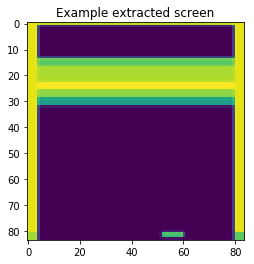

In [5]:
# Тут блок с кодом, генерирующим 1 кадр игры
# Обратите внимание, что выходным тензора является torch.ByteTensor со значениями 0-255
# Это сделанно намеренно для экономии места(4х экономия по сравнению с FloatTensor)
# Подумайте, где и как необходимо совершать преобразование ByteTensort -> FloatTensor, чтобы его можно было подавать в сеть. 

resize = T.Compose([T.ToPILImage(), T.Resize((STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach()

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
# Далее стандартный метод для выбора нового действия из лекции

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)

memory = ReplayMemory()
state_holder = StateHolder()

def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [7]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).float()  
    state_batch = torch.cat(batch.state).float()
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

Episode score : 0.0
Mean score : 1.2000000476837158
Model saved!
Episode score : 2.0
Mean score : 1.2100000381469727
Episode score : 0.0
Mean score : 1.190000057220459
Episode score : 1.0
Mean score : 1.1799999475479126
Episode score : 0.0
Mean score : 1.1399999856948853
Episode score : 1.0
Mean score : 1.149999976158142
Episode score : 3.0
Mean score : 1.159999966621399
Episode score : 2.0
Mean score : 1.1699999570846558
Episode score : 0.0
Mean score : 1.1699999570846558
Episode score : 3.0
Mean score : 1.2000000476837158
Episode score : 2.0
Mean score : 1.2100000381469727
Episode score : 0.0
Mean score : 1.2000000476837158
Episode score : 1.0
Mean score : 1.2100000381469727
Episode score : 0.0
Mean score : 1.190000057220459
Episode score : 0.0
Mean score : 1.1799999475479126
Episode score : 0.0
Mean score : 1.149999976158142
Episode score : 0.0
Mean score : 1.149999976158142
Episode score : 1.0
Mean score : 1.1399999856948853
Episode score : 0.0
Mean score : 1.1299999952316284
Episo

Episode score : 1.0
Mean score : 1.25
Episode score : 2.0
Mean score : 1.2699999809265137
Episode score : 1.0
Mean score : 1.2799999713897705
Episode score : 0.0
Mean score : 1.2699999809265137
Episode score : 2.0
Mean score : 1.2699999809265137
Target net updated!
Episode score : 3.0
Mean score : 1.2999999523162842
Episode score : 0.0
Mean score : 1.2799999713897705
Episode score : 1.0
Mean score : 1.2899999618530273
Episode score : 0.0
Mean score : 1.2599999904632568
Episode score : 0.0
Mean score : 1.2599999904632568
Episode score : 3.0
Mean score : 1.2300000190734863
Episode score : 2.0
Mean score : 1.2400000095367432
Episode score : 1.0
Mean score : 1.2400000095367432
Episode score : 1.0
Mean score : 1.2400000095367432
Episode score : 2.0
Mean score : 1.2300000190734863
Episode score : 1.0
Mean score : 1.2200000286102295
Episode score : 0.0
Mean score : 1.2000000476837158
Episode score : 2.0
Mean score : 1.190000057220459
Episode score : 0.0
Mean score : 1.1699999570846558
Episode

Target net updated!
Episode score : 2.0
Mean score : 1.7599999904632568
Episode score : 2.0
Mean score : 1.7400000095367432
Episode score : 1.0
Mean score : 1.7400000095367432
Episode score : 1.0
Mean score : 1.7300000190734863
Episode score : 2.0
Mean score : 1.7400000095367432
Episode score : 1.0
Mean score : 1.75
Episode score : 2.0
Mean score : 1.7699999809265137
Episode score : 2.0
Mean score : 1.7699999809265137
Episode score : 4.0
Mean score : 1.809999942779541
Episode score : 1.0
Mean score : 1.8200000524520874
Episode score : 2.0
Mean score : 1.840000033378601
Episode score : 0.0
Mean score : 1.840000033378601
Episode score : 1.0
Mean score : 1.7999999523162842
Episode score : 0.0
Mean score : 1.7599999904632568
Episode score : 2.0
Mean score : 1.7599999904632568
Episode score : 4.0
Mean score : 1.7799999713897705
Episode score : 3.0
Mean score : 1.7899999618530273
Episode score : 0.0
Mean score : 1.7400000095367432
Episode score : 1.0
Mean score : 1.7400000095367432
Episode s

Episode score : 0.0
Mean score : 2.0299999713897705
Episode score : 9.0
Mean score : 2.0999999046325684
Episode score : 2.0
Mean score : 2.109999895095825
Episode score : 1.0
Mean score : 2.0899999141693115
Episode score : 2.0
Mean score : 2.0999999046325684
Episode score : 0.0
Mean score : 2.0999999046325684
Episode score : 6.0
Mean score : 2.119999885559082
Episode score : 4.0
Mean score : 2.140000104904175
Episode score : 2.0
Mean score : 2.119999885559082
Episode score : 1.0
Mean score : 2.119999885559082
Episode score : 0.0
Mean score : 2.0999999046325684
Episode score : 0.0
Mean score : 2.049999952316284
Episode score : 0.0
Mean score : 2.049999952316284
Episode score : 1.0
Mean score : 2.0299999713897705
Episode score : 4.0
Mean score : 2.059999942779541
Episode score : 2.0
Mean score : 2.069999933242798
Episode score : 1.0
Mean score : 2.0799999237060547
Episode score : 0.0
Mean score : 2.059999942779541
Episode score : 2.0
Mean score : 2.069999933242798
Episode score : 0.0
Mea

Episode score : 6.0
Mean score : 2.25
Episode score : 0.0
Mean score : 2.2300000190734863
Episode score : 5.0
Mean score : 2.259999990463257
Episode score : 7.0
Mean score : 2.2799999713897705
Episode score : 2.0
Mean score : 2.299999952316284
Episode score : 3.0
Mean score : 2.299999952316284
Episode score : 1.0
Mean score : 2.2799999713897705
Episode score : 1.0
Mean score : 2.25
Episode score : 5.0
Mean score : 2.2699999809265137
Episode score : 3.0
Mean score : 2.2699999809265137
Episode score : 2.0
Mean score : 2.2699999809265137
Episode score : 3.0
Mean score : 2.2699999809265137
Episode score : 3.0
Mean score : 2.2699999809265137
Episode score : 2.0
Mean score : 2.240000009536743
Episode score : 6.0
Mean score : 2.2899999618530273
Episode score : 2.0
Mean score : 2.2899999618530273
Episode score : 2.0
Mean score : 2.2799999713897705
Episode score : 2.0
Mean score : 2.259999990463257
Episode score : 0.0
Mean score : 2.190000057220459
Episode score : 3.0
Mean score : 2.21000003814

Episode score : 3.0
Mean score : 2.640000104904175
Episode score : 7.0
Mean score : 2.680000066757202
Episode score : 3.0
Mean score : 2.640000104904175
Episode score : 3.0
Mean score : 2.630000114440918
Episode score : 4.0
Mean score : 2.640000104904175
Model saved!
Episode score : 5.0
Mean score : 2.6700000762939453
Episode score : 2.0
Mean score : 2.6700000762939453
Episode score : 2.0
Mean score : 2.6600000858306885
Episode score : 5.0
Mean score : 2.690000057220459
Episode score : 2.0
Mean score : 2.6600000858306885
Episode score : 4.0
Mean score : 2.6600000858306885
Episode score : 6.0
Mean score : 2.7100000381469727
Episode score : 3.0
Mean score : 2.680000066757202
Episode score : 3.0
Mean score : 2.6700000762939453
Episode score : 2.0
Mean score : 2.6600000858306885
Episode score : 3.0
Mean score : 2.6700000762939453
Episode score : 7.0
Mean score : 2.740000009536743
Episode score : 2.0
Mean score : 2.75
Episode score : 5.0
Mean score : 2.7799999713897705
Episode score : 4.0
M

Target net updated!
Episode score : 0.0
Mean score : 2.6500000953674316
Episode score : 3.0
Mean score : 2.6700000762939453
Episode score : 2.0
Mean score : 2.690000057220459
Episode score : 3.0
Mean score : 2.7100000381469727
Episode score : 0.0
Mean score : 2.690000057220459
Episode score : 6.0
Mean score : 2.690000057220459
Episode score : 3.0
Mean score : 2.680000066757202
Episode score : 3.0
Mean score : 2.690000057220459
Episode score : 1.0
Mean score : 2.6600000858306885
Episode score : 17.0
Mean score : 2.7799999713897705
Episode score : 5.0
Mean score : 2.809999942779541
Episode score : 3.0
Mean score : 2.7899999618530273
Episode score : 3.0
Mean score : 2.7899999618530273
Episode score : 5.0
Mean score : 2.7899999618530273
Episode score : 4.0
Mean score : 2.799999952316284
Episode score : 2.0
Mean score : 2.7799999713897705
Episode score : 5.0
Mean score : 2.809999942779541
Episode score : 6.0
Mean score : 2.809999942779541
Episode score : 1.0
Mean score : 2.799999952316284
E

Episode score : 6.0
Mean score : 3.549999952316284
Episode score : 6.0
Mean score : 3.5899999141693115
Episode score : 4.0
Mean score : 3.5899999141693115
Episode score : 3.0
Mean score : 3.5799999237060547
Episode score : 8.0
Mean score : 3.630000114440918
Episode score : 12.0
Mean score : 3.7200000286102295
Episode score : 1.0
Mean score : 3.700000047683716
Episode score : 3.0
Mean score : 3.7200000286102295
Target net updated!
Episode score : 4.0
Mean score : 3.7200000286102295
Episode score : 6.0
Mean score : 3.7200000286102295
Episode score : 6.0
Mean score : 3.7699999809265137
Episode score : 4.0
Mean score : 3.680000066757202
Episode score : 4.0
Mean score : 3.690000057220459
Episode score : 7.0
Mean score : 3.759999990463257
Episode score : 4.0
Mean score : 3.7699999809265137
Episode score : 2.0
Mean score : 3.75
Episode score : 2.0
Mean score : 3.740000009536743
Episode score : 2.0
Mean score : 3.7100000381469727
Episode score : 9.0
Mean score : 3.7899999618530273
Episode scor

Episode score : 6.0
Mean score : 3.809999942779541
Episode score : 4.0
Mean score : 3.8299999237060547
Episode score : 1.0
Mean score : 3.819999933242798
Episode score : 2.0
Mean score : 3.809999942779541
Episode score : 3.0
Mean score : 3.7899999618530273
Episode score : 5.0
Mean score : 3.8299999237060547
Episode score : 1.0
Mean score : 3.7699999809265137
Episode score : 1.0
Mean score : 3.75
Episode score : 5.0
Mean score : 3.75
Episode score : 2.0
Mean score : 3.700000047683716
Episode score : 2.0
Mean score : 3.7200000286102295
Episode score : 4.0
Mean score : 3.7200000286102295
Episode score : 10.0
Mean score : 3.7899999618530273
Episode score : 1.0
Mean score : 3.759999990463257
Target net updated!
Episode score : 3.0
Mean score : 3.7300000190734863
Episode score : 5.0
Mean score : 3.7799999713897705
Episode score : 3.0
Mean score : 3.7699999809265137
Episode score : 5.0
Mean score : 3.809999942779541
Episode score : 0.0
Mean score : 3.7799999713897705
Episode score : 6.0
Mean 

Episode score : 2.0
Mean score : 4.739999771118164
Target net updated!
Episode score : 6.0
Mean score : 4.730000019073486
Episode score : 7.0
Mean score : 4.78000020980835
Episode score : 5.0
Mean score : 4.78000020980835
Episode score : 1.0
Mean score : 4.710000038146973
Episode score : 8.0
Mean score : 4.760000228881836
Episode score : 9.0
Mean score : 4.820000171661377
Episode score : 3.0
Mean score : 4.800000190734863
Episode score : 6.0
Mean score : 4.789999961853027
Episode score : 7.0
Mean score : 4.809999942779541
Episode score : 4.0
Mean score : 4.78000020980835
Episode score : 8.0
Mean score : 4.840000152587891
Episode score : 6.0
Mean score : 4.880000114440918
Episode score : 6.0
Mean score : 4.889999866485596
Episode score : 3.0
Mean score : 4.869999885559082
Episode score : 7.0
Mean score : 4.909999847412109
Episode score : 2.0
Mean score : 4.880000114440918
Episode score : 4.0
Mean score : 4.840000152587891
Episode score : 5.0
Mean score : 4.829999923706055
Episode score 

Episode score : 3.0
Mean score : 4.539999961853027
Episode score : 7.0
Mean score : 4.579999923706055
Episode score : 5.0
Mean score : 4.599999904632568
Episode score : 4.0
Mean score : 4.619999885559082
Episode score : 7.0
Mean score : 4.610000133514404
Episode score : 4.0
Mean score : 4.599999904632568
Episode score : 1.0
Mean score : 4.559999942779541
Episode score : 1.0
Mean score : 4.53000020980835
Episode score : 7.0
Mean score : 4.53000020980835
Model saved!
Episode score : 4.0
Mean score : 4.539999961853027
Episode score : 7.0
Mean score : 4.510000228881836
Target net updated!
Episode score : 5.0
Mean score : 4.519999980926514
Episode score : 5.0
Mean score : 4.550000190734863
Episode score : 7.0
Mean score : 4.610000133514404
Episode score : 5.0
Mean score : 4.630000114440918
Episode score : 7.0
Mean score : 4.659999847412109
Episode score : 4.0
Mean score : 4.650000095367432
Episode score : 6.0
Mean score : 4.690000057220459
Episode score : 8.0
Mean score : 4.710000038146973


Episode score : 3.0
Mean score : 5.199999809265137
Episode score : 8.0
Mean score : 5.239999771118164
Episode score : 5.0
Mean score : 5.21999979019165
Episode score : 7.0
Mean score : 5.239999771118164
Episode score : 9.0
Mean score : 5.300000190734863
Episode score : 1.0
Mean score : 5.260000228881836
Episode score : 3.0
Mean score : 5.260000228881836
Episode score : 5.0
Mean score : 5.210000038146973
Episode score : 6.0
Mean score : 5.21999979019165
Episode score : 5.0
Mean score : 5.190000057220459
Episode score : 6.0
Mean score : 5.210000038146973
Episode score : 2.0
Mean score : 5.159999847412109
Episode score : 6.0
Mean score : 5.210000038146973
Target net updated!
Episode score : 4.0
Mean score : 5.210000038146973
Episode score : 8.0
Mean score : 5.25
Episode score : 5.0
Mean score : 5.230000019073486
Episode score : 8.0
Mean score : 5.239999771118164
Episode score : 5.0
Mean score : 5.21999979019165
Episode score : 17.0
Mean score : 5.349999904632568
Episode score : 10.0
Mean 

Episode score : 4.0
Mean score : 5.880000114440918
Episode score : 10.0
Mean score : 5.929999828338623
Episode score : 5.0
Mean score : 5.960000038146973
Target net updated!
Episode score : 11.0
Mean score : 6.050000190734863
Episode score : 1.0
Mean score : 6.039999961853027
Episode score : 6.0
Mean score : 6.059999942779541
Episode score : 9.0
Mean score : 6.110000133514404
Episode score : 4.0
Mean score : 6.099999904632568
Episode score : 7.0
Mean score : 6.099999904632568
Episode score : 4.0
Mean score : 6.050000190734863
Episode score : 6.0
Mean score : 6.059999942779541
Episode score : 1.0
Mean score : 6.019999980926514
Episode score : 11.0
Mean score : 6.050000190734863
Episode score : 5.0
Mean score : 6.039999961853027
Episode score : 10.0
Mean score : 6.079999923706055
Episode score : 2.0
Mean score : 6.050000190734863
Episode score : 6.0
Mean score : 6.019999980926514
Episode score : 8.0
Mean score : 6.079999923706055
Episode score : 8.0
Mean score : 6.130000114440918
Episode

Episode score : 4.0
Mean score : 6.28000020980835
Episode score : 7.0
Mean score : 6.300000190734863
Episode score : 8.0
Mean score : 6.340000152587891
Episode score : 8.0
Mean score : 6.389999866485596
Episode score : 6.0
Mean score : 6.360000133514404
Episode score : 5.0
Mean score : 6.360000133514404
Episode score : 3.0
Mean score : 6.360000133514404
Episode score : 2.0
Mean score : 6.349999904632568
Target net updated!
Episode score : 11.0
Mean score : 6.400000095367432
Episode score : 8.0
Mean score : 6.420000076293945
Episode score : 4.0
Mean score : 6.360000133514404
Episode score : 5.0
Mean score : 6.309999942779541
Episode score : 3.0
Mean score : 6.25
Episode score : 2.0
Mean score : 6.179999828338623
Episode score : 7.0
Mean score : 6.179999828338623
Episode score : 6.0
Mean score : 6.199999809265137
Episode score : 7.0
Mean score : 6.210000038146973
Episode score : 6.0
Mean score : 6.159999847412109
Episode score : 8.0
Mean score : 6.159999847412109
Episode score : 12.0
Mea

Episode score : 9.0
Mean score : 7.440000057220459
Episode score : 7.0
Mean score : 7.480000019073486
Episode score : 8.0
Mean score : 7.46999979019165
Episode score : 8.0
Mean score : 7.510000228881836
Episode score : 7.0
Mean score : 7.510000228881836
Target net updated!
Episode score : 7.0
Mean score : 7.519999980926514
Episode score : 6.0
Mean score : 7.46999979019165
Episode score : 5.0
Mean score : 7.360000133514404
Episode score : 6.0
Mean score : 7.360000133514404
Episode score : 2.0
Mean score : 7.309999942779541
Episode score : 9.0
Mean score : 7.360000133514404
Episode score : 7.0
Mean score : 7.360000133514404
Episode score : 11.0
Mean score : 7.320000171661377
Episode score : 6.0
Mean score : 7.369999885559082
Episode score : 11.0
Mean score : 7.349999904632568
Episode score : 20.0
Mean score : 7.53000020980835
Episode score : 9.0
Mean score : 7.570000171661377
Episode score : 12.0
Mean score : 7.550000190734863
Episode score : 7.0
Mean score : 7.550000190734863
Episode sc

Episode score : 9.0
Mean score : 8.489999771118164
Episode score : 5.0
Mean score : 8.5
Episode score : 15.0
Mean score : 8.630000114440918
Episode score : 14.0
Mean score : 8.649999618530273
Episode score : 7.0
Mean score : 8.630000114440918
Target net updated!
Episode score : 8.0
Mean score : 8.670000076293945
Episode score : 7.0
Mean score : 8.699999809265137
Episode score : 3.0
Mean score : 8.65999984741211
Episode score : 4.0
Mean score : 8.640000343322754
Episode score : 6.0
Mean score : 8.65999984741211
Episode score : 14.0
Mean score : 8.680000305175781
Episode score : 9.0
Mean score : 8.710000038146973
Episode score : 5.0
Mean score : 8.65999984741211
Episode score : 8.0
Mean score : 8.6899995803833
Model saved!
Episode score : 5.0
Mean score : 8.680000305175781
Episode score : 12.0
Mean score : 8.739999771118164
Episode score : 6.0
Mean score : 8.75
Episode score : 7.0
Mean score : 8.720000267028809
Episode score : 9.0
Mean score : 8.720000267028809
Episode score : 8.0
Mean s

Episode score : 13.0
Mean score : 8.949999809265137
Episode score : 8.0
Mean score : 8.949999809265137
Episode score : 5.0
Mean score : 8.979999542236328
Target net updated!
Episode score : 12.0
Mean score : 9.0
Episode score : 5.0
Mean score : 8.920000076293945
Episode score : 10.0
Mean score : 8.880000114440918
Episode score : 10.0
Mean score : 8.869999885559082
Episode score : 14.0
Mean score : 8.9399995803833
Episode score : 7.0
Mean score : 8.920000076293945
Episode score : 11.0
Mean score : 8.920000076293945
Episode score : 7.0
Mean score : 8.899999618530273
Episode score : 3.0
Mean score : 8.829999923706055
Episode score : 23.0
Mean score : 9.020000457763672
Episode score : 8.0
Mean score : 8.989999771118164
Episode score : 6.0
Mean score : 8.960000038146973
Episode score : 10.0
Mean score : 9.029999732971191
Episode score : 4.0
Mean score : 9.010000228881836
Episode score : 15.0
Mean score : 9.09000015258789
Episode score : 8.0
Mean score : 9.079999923706055
Episode score : 4.0

Episode score : 13.0
Mean score : 9.239999771118164
Episode score : 7.0
Mean score : 9.199999809265137
Episode score : 13.0
Mean score : 9.270000457763672
Episode score : 8.0
Mean score : 9.3100004196167
Episode score : 11.0
Mean score : 9.3100004196167
Episode score : 16.0
Mean score : 9.390000343322754
Episode score : 12.0
Mean score : 9.359999656677246
Episode score : 17.0
Mean score : 9.470000267028809
Episode score : 15.0
Mean score : 9.569999694824219
Episode score : 4.0
Mean score : 9.550000190734863
Episode score : 13.0
Mean score : 9.550000190734863
Episode score : 7.0
Mean score : 9.5
Target net updated!
Episode score : 14.0
Mean score : 9.510000228881836
Episode score : 10.0
Mean score : 9.539999961853027
Episode score : 5.0
Mean score : 9.550000190734863
Episode score : 7.0
Mean score : 9.5600004196167
Episode score : 12.0
Mean score : 9.5600004196167
Episode score : 5.0
Mean score : 9.5
Episode score : 14.0
Mean score : 9.539999961853027
Episode score : 14.0
Mean score : 9

Episode score : 12.0
Mean score : 10.640000343322754
Episode score : 8.0
Mean score : 10.649999618530273
Episode score : 15.0
Mean score : 10.720000267028809
Episode score : 9.0
Mean score : 10.680000305175781
Episode score : 13.0
Mean score : 10.720000267028809
Episode score : 12.0
Mean score : 10.800000190734863
Episode score : 12.0
Mean score : 10.770000457763672
Episode score : 11.0
Mean score : 10.850000381469727
Episode score : 11.0
Mean score : 10.850000381469727
Target net updated!
Episode score : 16.0
Mean score : 10.960000038146973
Episode score : 13.0
Mean score : 11.0
Episode score : 15.0
Mean score : 11.079999923706055
Episode score : 14.0
Mean score : 11.079999923706055
Episode score : 18.0
Mean score : 11.119999885559082
Episode score : 17.0
Mean score : 11.170000076293945
Episode score : 9.0
Mean score : 11.130000114440918
Episode score : 5.0
Mean score : 11.079999923706055
Episode score : 4.0
Mean score : 10.970000267028809
Episode score : 36.0
Mean score : 11.22999954

Episode score : 26.0
Mean score : 12.8100004196167
Episode score : 11.0
Mean score : 12.75
Episode score : 23.0
Mean score : 12.90999984741211
Episode score : 20.0
Mean score : 13.0600004196167
Episode score : 14.0
Mean score : 13.069999694824219
Episode score : 12.0
Mean score : 13.039999961853027
Episode score : 12.0
Mean score : 13.039999961853027
Target net updated!
Episode score : 20.0
Mean score : 13.140000343322754
Episode score : 3.0
Mean score : 13.079999923706055
Episode score : 6.0
Mean score : 13.0600004196167
Episode score : 14.0
Mean score : 13.149999618530273
Episode score : 10.0
Mean score : 13.109999656677246
Episode score : 16.0
Mean score : 13.130000114440918
Episode score : 12.0
Mean score : 13.130000114440918
Episode score : 19.0
Mean score : 13.210000038146973
Episode score : 8.0
Mean score : 13.15999984741211
Episode score : 7.0
Mean score : 13.140000343322754
Episode score : 12.0
Mean score : 13.119999885559082
Episode score : 17.0
Mean score : 13.17000007629394

Episode score : 2.0
Mean score : 12.369999885559082
Episode score : 16.0
Mean score : 12.4399995803833
Episode score : 7.0
Mean score : 12.4399995803833
Episode score : 18.0
Mean score : 12.5
Episode score : 11.0
Mean score : 12.449999809265137
Target net updated!
Episode score : 18.0
Mean score : 12.539999961853027
Episode score : 27.0
Mean score : 12.729999542236328
Episode score : 11.0
Mean score : 12.720000267028809
Episode score : 10.0
Mean score : 12.65999984741211
Episode score : 12.0
Mean score : 12.699999809265137
Episode score : 23.0
Mean score : 12.789999961853027
Episode score : 8.0
Mean score : 12.699999809265137
Episode score : 25.0
Mean score : 12.90999984741211
Episode score : 10.0
Mean score : 12.84000015258789
Episode score : 8.0
Mean score : 12.680000305175781
Episode score : 4.0
Mean score : 12.640000343322754
Episode score : 8.0
Mean score : 12.600000381469727
Episode score : 34.0
Mean score : 12.710000038146973
Target net updated!
Episode score : 9.0
Mean score : 

Episode score : 15.0
Mean score : 14.180000305175781
Episode score : 12.0
Mean score : 14.119999885559082
Episode score : 9.0
Mean score : 14.130000114440918
Episode score : 18.0
Mean score : 14.170000076293945
Episode score : 15.0
Mean score : 14.140000343322754
Episode score : 7.0
Mean score : 14.140000343322754
Episode score : 23.0
Mean score : 14.199999809265137
Episode score : 13.0
Mean score : 14.25
Episode score : 17.0
Mean score : 14.279999732971191
Episode score : 6.0
Mean score : 14.270000457763672
Episode score : 11.0
Mean score : 14.279999732971191
Episode score : 19.0
Mean score : 14.430000305175781
Target net updated!
Episode score : 11.0
Mean score : 14.470000267028809
Episode score : 6.0
Mean score : 14.470000267028809
Episode score : 1.0
Mean score : 14.199999809265137
Episode score : 19.0
Mean score : 14.239999771118164
Episode score : 22.0
Mean score : 14.289999961853027
Episode score : 16.0
Mean score : 14.359999656677246
Episode score : 5.0
Mean score : 14.27999973

Episode score : 24.0
Mean score : 14.789999961853027
Episode score : 12.0
Mean score : 14.75
Episode score : 15.0
Mean score : 14.8100004196167
Episode score : 11.0
Mean score : 14.649999618530273
Episode score : 30.0
Mean score : 14.789999961853027
Episode score : 6.0
Mean score : 14.699999809265137
Episode score : 10.0
Mean score : 14.550000190734863
Episode score : 16.0
Mean score : 14.510000228881836
Target net updated!
Episode score : 14.0
Mean score : 14.529999732971191
Episode score : 17.0
Mean score : 14.420000076293945
Episode score : 10.0
Mean score : 14.420000076293945
Episode score : 18.0
Mean score : 14.380000114440918
Episode score : 17.0
Mean score : 14.390000343322754
Episode score : 24.0
Mean score : 14.479999542236328
Episode score : 6.0
Mean score : 14.4399995803833
Episode score : 23.0
Mean score : 14.619999885559082
Episode score : 13.0
Mean score : 14.569999694824219
Episode score : 17.0
Mean score : 14.65999984741211
Episode score : 7.0
Mean score : 14.3999996185

Episode score : 21.0
Mean score : 14.8100004196167
Episode score : 21.0
Mean score : 14.800000190734863
Episode score : 9.0
Mean score : 14.6899995803833
Episode score : 26.0
Mean score : 14.779999732971191
Episode score : 10.0
Mean score : 14.59000015258789
Episode score : 13.0
Mean score : 14.65999984741211
Target net updated!
Episode score : 10.0
Mean score : 14.609999656677246
Episode score : 9.0
Mean score : 14.579999923706055
Episode score : 12.0
Mean score : 14.529999732971191
Episode score : 20.0
Mean score : 14.510000228881836
Episode score : 44.0
Mean score : 14.869999885559082
Episode score : 5.0
Mean score : 14.619999885559082
Episode score : 9.0
Mean score : 14.569999694824219
Episode score : 11.0
Mean score : 14.529999732971191
Episode score : 6.0
Mean score : 14.5
Episode score : 12.0
Mean score : 14.529999732971191
Episode score : 30.0
Mean score : 14.710000038146973
Episode score : 17.0
Mean score : 14.770000457763672
Episode score : 19.0
Mean score : 14.76000022888183

Episode score : 9.0
Mean score : 15.109999656677246
Target net updated!
Episode score : 10.0
Mean score : 15.010000228881836
Episode score : 16.0
Mean score : 15.010000228881836
Episode score : 15.0
Mean score : 15.029999732971191
Episode score : 20.0
Mean score : 15.050000190734863
Episode score : 15.0
Mean score : 15.119999885559082
Episode score : 11.0
Mean score : 15.119999885559082
Episode score : 25.0
Mean score : 15.3100004196167
Episode score : 12.0
Mean score : 15.3100004196167
Episode score : 21.0
Mean score : 15.300000190734863
Episode score : 20.0
Mean score : 15.380000114440918
Episode score : 17.0
Mean score : 15.369999885559082
Episode score : 24.0
Mean score : 15.5
Target net updated!
Episode score : 11.0
Mean score : 15.510000228881836
Episode score : 20.0
Mean score : 15.59000015258789
Episode score : 32.0
Mean score : 15.84000015258789
Episode score : 16.0
Mean score : 15.869999885559082
Episode score : 16.0
Mean score : 15.729999542236328
Episode score : 12.0
Mean s

Target net updated!
Episode score : 17.0
Mean score : 16.170000076293945
Episode score : 18.0
Mean score : 16.200000762939453
Episode score : 21.0
Mean score : 16.290000915527344
Episode score : 17.0
Mean score : 16.350000381469727
Episode score : 31.0
Mean score : 16.559999465942383
Episode score : 37.0
Mean score : 16.729999542236328
Episode score : 14.0
Mean score : 16.739999771118164
Episode score : 13.0
Mean score : 16.68000030517578
Episode score : 16.0
Mean score : 16.65999984741211
Episode score : 18.0
Mean score : 16.579999923706055
Target net updated!
Episode score : 28.0
Mean score : 16.739999771118164
Episode score : 13.0
Mean score : 16.670000076293945
Episode score : 24.0
Mean score : 16.84000015258789
Episode score : 21.0
Mean score : 16.93000030517578
Episode score : 34.0
Mean score : 17.1200008392334
Episode score : 9.0
Mean score : 17.09000015258789
Episode score : 16.0
Mean score : 17.110000610351562
Episode score : 20.0
Mean score : 17.229999542236328
Episode score 

Episode score : 23.0
Mean score : 16.309999465942383
Episode score : 5.0
Mean score : 16.209999084472656
Episode score : 18.0
Mean score : 16.299999237060547
Episode score : 19.0
Mean score : 16.25
Episode score : 10.0
Mean score : 16.15999984741211
Episode score : 16.0
Mean score : 16.190000534057617
Episode score : 26.0
Mean score : 16.15999984741211
Episode score : 24.0
Mean score : 16.34000015258789
Episode score : 36.0
Mean score : 16.5
Target net updated!
Episode score : 19.0
Mean score : 16.600000381469727
Episode score : 17.0
Mean score : 16.559999465942383
Episode score : 21.0
Mean score : 16.600000381469727
Episode score : 13.0
Mean score : 16.389999389648438
Episode score : 10.0
Mean score : 16.420000076293945
Episode score : 17.0
Mean score : 16.329999923706055
Episode score : 32.0
Mean score : 16.56999969482422
Model saved!
Episode score : 14.0
Mean score : 16.489999771118164
Episode score : 20.0
Mean score : 16.559999465942383
Episode score : 5.0
Mean score : 16.430000305

Episode score : 13.0
Mean score : 19.059999465942383
Target net updated!
Episode score : 30.0
Mean score : 19.040000915527344
Episode score : 8.0
Mean score : 19.010000228881836
Episode score : 13.0
Mean score : 19.059999465942383
Episode score : 23.0
Mean score : 19.049999237060547
Episode score : 20.0
Mean score : 19.170000076293945
Episode score : 14.0
Mean score : 19.239999771118164
Episode score : 14.0
Mean score : 19.170000076293945
Episode score : 16.0
Mean score : 19.100000381469727
Episode score : 31.0
Mean score : 19.209999084472656
Episode score : 24.0
Mean score : 19.309999465942383
Episode score : 10.0
Mean score : 19.31999969482422
Target net updated!
Episode score : 27.0
Mean score : 19.3799991607666
Episode score : 20.0
Mean score : 19.459999084472656
Episode score : 15.0
Mean score : 19.360000610351562
Episode score : 17.0
Mean score : 19.420000076293945
Episode score : 26.0
Mean score : 19.290000915527344
Episode score : 14.0
Mean score : 19.200000762939453
Episode sc

Episode score : 13.0
Mean score : 18.219999313354492
Episode score : 30.0
Mean score : 18.329999923706055
Episode score : 27.0
Mean score : 18.459999084472656
Episode score : 26.0
Mean score : 18.6200008392334
Episode score : 12.0
Mean score : 18.559999465942383
Episode score : 28.0
Mean score : 18.639999389648438
Episode score : 20.0
Mean score : 18.68000030517578
Episode score : 33.0
Mean score : 18.809999465942383
Episode score : 21.0
Mean score : 18.809999465942383
Target net updated!
Episode score : 29.0
Mean score : 18.889999389648438
Episode score : 15.0
Mean score : 18.950000762939453
Episode score : 32.0
Mean score : 19.040000915527344
Model saved!
Episode score : 14.0
Mean score : 19.059999465942383
Episode score : 8.0
Mean score : 19.059999465942383
Episode score : 15.0
Mean score : 19.059999465942383
Episode score : 37.0
Mean score : 19.270000457763672
Episode score : 11.0
Mean score : 19.280000686645508
Episode score : 21.0
Mean score : 19.3700008392334
Episode score : 11.

Episode score : 59.0
Mean score : 23.709999084472656
Episode score : 30.0
Mean score : 23.809999465942383
Episode score : 30.0
Mean score : 23.860000610351562
Target net updated!
Episode score : 48.0
Mean score : 24.260000228881836
Episode score : 32.0
Mean score : 24.360000610351562
Episode score : 10.0
Mean score : 24.1299991607666
Episode score : 14.0
Mean score : 24.139999389648438
Episode score : 14.0
Mean score : 24.079999923706055
Episode score : 14.0
Mean score : 24.040000915527344
Episode score : 25.0
Mean score : 24.059999465942383
Episode score : 20.0
Mean score : 24.059999465942383
Episode score : 23.0
Mean score : 24.110000610351562
Episode score : 15.0
Mean score : 24.100000381469727
Target net updated!
Episode score : 15.0
Mean score : 23.969999313354492
Episode score : 37.0
Mean score : 24.139999389648438
Episode score : 15.0
Mean score : 23.8700008392334
Episode score : 27.0
Mean score : 23.799999237060547
Episode score : 34.0
Mean score : 23.81999969482422
Episode sco

Episode score : 12.0
Mean score : 24.90999984741211
Episode score : 11.0
Mean score : 24.860000610351562
Episode score : 13.0
Mean score : 24.65999984741211
Episode score : 8.0
Mean score : 24.649999618530273
Episode score : 42.0
Mean score : 24.84000015258789
Target net updated!
Episode score : 36.0
Mean score : 25.1200008392334
Episode score : 14.0
Mean score : 25.09000015258789
Episode score : 22.0
Mean score : 25.1299991607666
Model saved!
Episode score : 14.0
Mean score : 25.110000610351562
Episode score : 26.0
Mean score : 24.950000762939453
Episode score : 36.0
Mean score : 25.100000381469727
Episode score : 15.0
Mean score : 25.100000381469727
Episode score : 15.0
Mean score : 24.93000030517578
Episode score : 33.0
Mean score : 24.989999771118164
Episode score : 28.0
Mean score : 25.1299991607666
Target net updated!
Episode score : 23.0
Mean score : 25.09000015258789
Episode score : 30.0
Mean score : 25.1200008392334
Episode score : 32.0
Mean score : 25.290000915527344
Episode 

Episode score : 17.0
Mean score : 22.579999923706055
Episode score : 13.0
Mean score : 22.43000030517578
Episode score : 5.0
Mean score : 22.3799991607666
Target net updated!
Episode score : 29.0
Mean score : 22.59000015258789
Episode score : 33.0
Mean score : 22.690000534057617
Episode score : 14.0
Mean score : 22.510000228881836
Episode score : 17.0
Mean score : 22.360000610351562
Episode score : 9.0
Mean score : 22.290000915527344
Episode score : 27.0
Mean score : 22.360000610351562
Episode score : 22.0
Mean score : 22.450000762939453
Episode score : 25.0
Mean score : 22.489999771118164
Episode score : 27.0
Mean score : 22.540000915527344
Episode score : 19.0
Mean score : 22.5
Target net updated!
Episode score : 31.0
Mean score : 22.56999969482422
Episode score : 18.0
Mean score : 22.700000762939453
Episode score : 18.0
Mean score : 22.68000030517578
Episode score : 12.0
Mean score : 22.639999389648438
Episode score : 23.0
Mean score : 22.610000610351562
Episode score : 43.0
Mean sc

Episode score : 39.0
Mean score : 24.030000686645508
Episode score : 26.0
Mean score : 24.1299991607666
Target net updated!
Episode score : 20.0
Mean score : 24.1200008392334
Episode score : 46.0
Mean score : 24.309999465942383
Episode score : 22.0
Mean score : 24.299999237060547
Model saved!
Episode score : 14.0
Mean score : 24.270000457763672
Episode score : 40.0
Mean score : 24.190000534057617
Episode score : 28.0
Mean score : 24.040000915527344
Episode score : 20.0
Mean score : 23.84000015258789
Episode score : 13.0
Mean score : 23.700000762939453
Episode score : 34.0
Mean score : 23.860000610351562
Episode score : 22.0
Mean score : 23.93000030517578
Target net updated!
Episode score : 36.0
Mean score : 23.889999389648438
Episode score : 27.0
Mean score : 23.899999618530273
Episode score : 19.0
Mean score : 23.93000030517578
Episode score : 26.0
Mean score : 24.100000381469727
Episode score : 17.0
Mean score : 24.190000534057617
Episode score : 15.0
Mean score : 24.06999969482422
E

Episode score : 22.0
Mean score : 22.920000076293945
Episode score : 29.0
Mean score : 22.940000534057617
Episode score : 33.0
Mean score : 22.989999771118164
Episode score : 12.0
Mean score : 22.959999084472656
Episode score : 5.0
Mean score : 22.899999618530273
Episode score : 36.0
Mean score : 23.100000381469727
Episode score : 10.0
Mean score : 22.84000015258789
Episode score : 16.0
Mean score : 22.809999465942383
Target net updated!
Episode score : 17.0
Mean score : 22.84000015258789
Episode score : 15.0
Mean score : 22.549999237060547
Episode score : 15.0
Mean score : 22.579999923706055
Episode score : 34.0
Mean score : 22.75
Episode score : 31.0
Mean score : 22.950000762939453
Episode score : 33.0
Mean score : 22.950000762939453
Episode score : 9.0
Mean score : 22.770000457763672
Episode score : 31.0
Mean score : 22.829999923706055
Episode score : 32.0
Mean score : 22.8799991607666
Episode score : 12.0
Mean score : 22.739999771118164
Target net updated!
Episode score : 22.0
Mean

Target net updated!
Episode score : 30.0
Mean score : 23.030000686645508
Episode score : 39.0
Mean score : 23.229999542236328
Episode score : 32.0
Mean score : 23.389999389648438
Model saved!
Episode score : 8.0
Mean score : 23.329999923706055
Episode score : 47.0
Mean score : 23.559999465942383
Episode score : 16.0
Mean score : 23.420000076293945
Episode score : 11.0
Mean score : 23.360000610351562
Episode score : 13.0
Mean score : 23.270000457763672
Episode score : 19.0
Mean score : 23.239999771118164
Episode score : 11.0
Mean score : 23.139999389648438
Target net updated!
Episode score : 23.0
Mean score : 23.030000686645508
Episode score : 20.0
Mean score : 22.899999618530273
Episode score : 17.0
Mean score : 22.899999618530273
Episode score : 17.0
Mean score : 22.940000534057617
Episode score : 17.0
Mean score : 22.75
Episode score : 13.0
Mean score : 22.68000030517578
Episode score : 17.0
Mean score : 22.65999984741211
Episode score : 22.0
Mean score : 22.65999984741211
Episode sc

Episode score : 28.0
Mean score : 27.280000686645508
Episode score : 45.0
Mean score : 27.34000015258789
Episode score : 8.0
Mean score : 27.229999542236328
Episode score : 23.0
Mean score : 27.280000686645508
Target net updated!
Episode score : 17.0
Mean score : 27.280000686645508
Episode score : 9.0
Mean score : 27.149999618530273
Episode score : 17.0
Mean score : 27.030000686645508
Episode score : 12.0
Mean score : 26.90999984741211
Episode score : 11.0
Mean score : 26.81999969482422
Episode score : 25.0
Mean score : 26.81999969482422
Episode score : 22.0
Mean score : 26.729999542236328
Episode score : 24.0
Mean score : 26.65999984741211
Episode score : 29.0
Mean score : 26.6299991607666
Episode score : 20.0
Mean score : 26.600000381469727
Episode score : 21.0
Mean score : 26.489999771118164
Target net updated!
Episode score : 15.0
Mean score : 26.440000534057617
Episode score : 15.0
Mean score : 26.40999984741211
Episode score : 46.0
Mean score : 26.469999313354492
Episode score : 

Episode score : 12.0
Mean score : 24.780000686645508
Model saved!
Episode score : 43.0
Mean score : 24.899999618530273
Episode score : 27.0
Mean score : 25.049999237060547
Episode score : 16.0
Mean score : 25.059999465942383
Target net updated!
Episode score : 39.0
Mean score : 25.1299991607666
Episode score : 53.0
Mean score : 25.3799991607666
Episode score : 29.0
Mean score : 25.469999313354492
Episode score : 35.0
Mean score : 25.670000076293945
Episode score : 25.0
Mean score : 25.719999313354492
Episode score : 22.0
Mean score : 25.770000457763672
Episode score : 23.0
Mean score : 25.559999465942383
Episode score : 25.0
Mean score : 25.540000915527344
Target net updated!
Episode score : 41.0
Mean score : 25.450000762939453
Episode score : 55.0
Mean score : 25.829999923706055
Episode score : 27.0
Mean score : 25.68000030517578
Episode score : 23.0
Mean score : 25.6200008392334
Episode score : 32.0
Mean score : 25.40999984741211
Episode score : 19.0
Mean score : 25.139999389648438
E

Episode score : 13.0
Mean score : 24.739999771118164
Episode score : 32.0
Mean score : 24.770000457763672
Episode score : 16.0
Mean score : 24.760000228881836
Episode score : 17.0
Mean score : 24.420000076293945
Episode score : 14.0
Mean score : 24.450000762939453
Episode score : 28.0
Mean score : 24.479999542236328
Episode score : 16.0
Mean score : 24.18000030517578
Episode score : 31.0
Mean score : 24.299999237060547
Episode score : 19.0
Mean score : 24.209999084472656
Target net updated!
Episode score : 17.0
Mean score : 24.149999618530273
Episode score : 46.0
Mean score : 24.329999923706055
Episode score : 27.0
Mean score : 24.479999542236328
Episode score : 50.0
Mean score : 24.530000686645508
Episode score : 15.0
Mean score : 24.459999084472656
Episode score : 16.0
Mean score : 24.200000762939453
Episode score : 29.0
Mean score : 24.239999771118164
Episode score : 30.0
Mean score : 24.469999313354492
Target net updated!
Episode score : 10.0
Mean score : 24.209999084472656
Episode

Episode score : 25.0
Mean score : 27.540000915527344
Episode score : 43.0
Mean score : 27.780000686645508
Episode score : 25.0
Mean score : 27.649999618530273
Episode score : 36.0
Mean score : 27.700000762939453
Target net updated!
Episode score : 28.0
Mean score : 27.899999618530273
Episode score : 37.0
Mean score : 28.020000457763672
Episode score : 24.0
Mean score : 28.0
Episode score : 39.0
Mean score : 27.790000915527344
Episode score : 19.0
Mean score : 27.940000534057617
Episode score : 20.0
Mean score : 27.93000030517578
Episode score : 18.0
Mean score : 27.979999542236328
Episode score : 33.0
Mean score : 27.920000076293945
Episode score : 18.0
Mean score : 27.899999618530273
Target net updated!
Episode score : 33.0
Mean score : 28.09000015258789
Episode score : 21.0
Mean score : 26.1200008392334
Episode score : 38.0
Mean score : 26.270000457763672
Episode score : 16.0
Mean score : 26.139999389648438
Episode score : 16.0
Mean score : 26.030000686645508
Episode score : 37.0
Mea

Target net updated!
Episode score : 24.0
Mean score : 26.09000015258789
Episode score : 14.0
Mean score : 26.15999984741211
Episode score : 29.0
Mean score : 26.100000381469727
Episode score : 32.0
Mean score : 26.31999969482422
Episode score : 20.0
Mean score : 26.260000228881836
Episode score : 13.0
Mean score : 26.229999542236328
Episode score : 6.0
Mean score : 26.010000228881836
Episode score : 20.0
Mean score : 25.979999542236328
Episode score : 30.0
Mean score : 25.739999771118164
Episode score : 10.0
Mean score : 25.219999313354492
Episode score : 21.0
Mean score : 25.209999084472656
Target net updated!
Episode score : 28.0
Mean score : 25.15999984741211
Episode score : 14.0
Mean score : 25.15999984741211
Episode score : 9.0
Mean score : 25.040000915527344
Episode score : 17.0
Mean score : 25.059999465942383
Episode score : 38.0
Mean score : 25.170000076293945
Episode score : 47.0
Mean score : 25.350000381469727
Episode score : 19.0
Mean score : 25.209999084472656
Episode score

Episode score : 16.0
Mean score : 25.190000534057617
Episode score : 54.0
Mean score : 25.65999984741211
Episode score : 29.0
Mean score : 25.829999923706055
Episode score : 18.0
Mean score : 25.829999923706055
Episode score : 27.0
Mean score : 25.780000686645508
Episode score : 10.0
Mean score : 25.579999923706055
Target net updated!
Episode score : 44.0
Mean score : 25.90999984741211
Episode score : 48.0
Mean score : 26.219999313354492
Episode score : 10.0
Mean score : 26.209999084472656
Episode score : 28.0
Mean score : 26.290000915527344
Episode score : 4.0
Mean score : 26.149999618530273
Episode score : 28.0
Mean score : 26.1200008392334
Episode score : 19.0
Mean score : 25.93000030517578
Episode score : 35.0
Mean score : 26.059999465942383
Episode score : 28.0
Mean score : 26.170000076293945
Target net updated!
Episode score : 16.0
Mean score : 26.0
Episode score : 35.0
Mean score : 26.25
Episode score : 35.0
Mean score : 26.440000534057617
Episode score : 41.0
Mean score : 26.55

Episode score : 33.0
Mean score : 27.3700008392334
Episode score : 22.0
Mean score : 27.3799991607666
Episode score : 23.0
Mean score : 27.1299991607666
Episode score : 20.0
Mean score : 27.010000228881836
Episode score : 34.0
Mean score : 27.1200008392334
Episode score : 18.0
Mean score : 26.989999771118164
Target net updated!
Episode score : 32.0
Mean score : 27.049999237060547
Episode score : 25.0
Mean score : 26.93000030517578
Episode score : 23.0
Mean score : 26.889999389648438
Episode score : 21.0
Mean score : 26.81999969482422
Episode score : 29.0
Mean score : 26.969999313354492
Episode score : 46.0
Mean score : 27.329999923706055
Episode score : 17.0
Mean score : 27.010000228881836
Episode score : 10.0
Mean score : 26.81999969482422
Episode score : 10.0
Mean score : 26.760000228881836
Episode score : 21.0
Mean score : 26.8700008392334
Target net updated!
Episode score : 8.0
Mean score : 26.649999618530273
Episode score : 25.0
Mean score : 26.540000915527344
Episode score : 17.0

Target net updated!
Episode score : 39.0
Mean score : 25.280000686645508
Episode score : 20.0
Mean score : 25.290000915527344
Episode score : 11.0
Mean score : 25.239999771118164
Episode score : 21.0
Mean score : 24.979999542236328
Episode score : 50.0
Mean score : 25.200000762939453
Episode score : 25.0
Mean score : 25.280000686645508
Episode score : 33.0
Mean score : 25.440000534057617
Episode score : 28.0
Mean score : 25.600000381469727
Target net updated!
Episode score : 45.0
Mean score : 25.780000686645508
Episode score : 15.0
Mean score : 25.809999465942383
Episode score : 38.0
Mean score : 26.030000686645508
Episode score : 24.0
Mean score : 26.09000015258789
Episode score : 40.0
Mean score : 25.950000762939453
Episode score : 20.0
Mean score : 25.959999084472656
Episode score : 15.0
Mean score : 25.920000076293945
Episode score : 12.0
Mean score : 25.90999984741211
Episode score : 33.0
Mean score : 25.809999465942383
Episode score : 10.0
Mean score : 25.709999084472656
Target n

Episode score : 38.0
Mean score : 27.329999923706055
Episode score : 62.0
Mean score : 27.549999237060547
Episode score : 39.0
Mean score : 27.649999618530273
Episode score : 38.0
Mean score : 27.84000015258789
Episode score : 23.0
Mean score : 27.81999969482422
Episode score : 13.0
Mean score : 27.6200008392334
Episode score : 35.0
Mean score : 27.469999313354492
Target net updated!
Episode score : 16.0
Mean score : 27.3700008392334
Episode score : 22.0
Mean score : 27.420000076293945
Episode score : 31.0
Mean score : 27.399999618530273
Episode score : 30.0
Mean score : 27.610000610351562
Episode score : 38.0
Mean score : 27.75
Episode score : 52.0
Mean score : 28.040000915527344
Episode score : 31.0
Mean score : 27.950000762939453
Episode score : 31.0
Mean score : 27.969999313354492
Target net updated!
Episode score : 35.0
Mean score : 28.18000030517578
Episode score : 52.0
Mean score : 28.530000686645508
Episode score : 55.0
Mean score : 28.760000228881836
Episode score : 43.0
Mean 

Episode score : 47.0
Mean score : 30.149999618530273
Episode score : 35.0
Mean score : 30.25
Episode score : 59.0
Mean score : 30.56999969482422
Episode score : 28.0
Mean score : 30.40999984741211
Target net updated!
Episode score : 18.0
Mean score : 30.280000686645508
Episode score : 41.0
Mean score : 30.170000076293945
Episode score : 17.0
Mean score : 29.950000762939453
Episode score : 70.0
Mean score : 30.389999389648438
Episode score : 25.0
Mean score : 30.399999618530273
Episode score : 61.0
Mean score : 30.700000762939453
Episode score : 21.0
Mean score : 30.149999618530273
Episode score : 15.0
Mean score : 30.190000534057617
Target net updated!
Episode score : 9.0
Mean score : 29.56999969482422
Episode score : 23.0
Mean score : 29.200000762939453
Episode score : 29.0
Mean score : 29.239999771118164
Episode score : 78.0
Mean score : 29.850000381469727
Episode score : 33.0
Mean score : 29.8799991607666
Episode score : 26.0
Mean score : 29.860000610351562
Episode score : 17.0
Mean

Episode score : 38.0
Mean score : 26.940000534057617
Episode score : 12.0
Mean score : 26.649999618530273
Episode score : 11.0
Mean score : 26.639999389648438
Episode score : 33.0
Mean score : 26.920000076293945
Target net updated!
Episode score : 34.0
Mean score : 27.010000228881836
Episode score : 36.0
Mean score : 26.690000534057617
Episode score : 34.0
Mean score : 26.860000610351562
Episode score : 24.0
Mean score : 26.8700008392334
Episode score : 36.0
Mean score : 27.100000381469727
Episode score : 34.0
Mean score : 27.239999771118164
Episode score : 22.0
Mean score : 27.0
Episode score : 27.0
Mean score : 27.100000381469727
Episode score : 30.0
Mean score : 27.200000762939453
Target net updated!
Episode score : 32.0
Mean score : 27.389999389648438
Episode score : 45.0
Mean score : 27.360000610351562
Episode score : 30.0
Mean score : 27.540000915527344
Episode score : 82.0
Mean score : 28.059999465942383
Episode score : 22.0
Mean score : 28.100000381469727
Episode score : 55.0
M

Episode score : 56.0
Mean score : 27.959999084472656
Episode score : 24.0
Mean score : 27.899999618530273
Episode score : 35.0
Mean score : 27.969999313354492
Episode score : 19.0
Mean score : 27.979999542236328
Episode score : 24.0
Mean score : 27.8700008392334
Target net updated!
Episode score : 31.0
Mean score : 27.799999237060547
Episode score : 32.0
Mean score : 28.010000228881836
Episode score : 13.0
Mean score : 27.93000030517578
Episode score : 18.0
Mean score : 28.100000381469727
Episode score : 23.0
Mean score : 28.260000228881836
Episode score : 40.0
Mean score : 28.43000030517578
Episode score : 19.0
Mean score : 28.309999465942383
Episode score : 24.0
Mean score : 28.40999984741211
Episode score : 29.0
Mean score : 28.489999771118164
Target net updated!
Episode score : 27.0
Mean score : 28.360000610351562
Episode score : 13.0
Mean score : 28.25
Episode score : 36.0
Mean score : 28.459999084472656
Episode score : 37.0
Mean score : 28.65999984741211
Episode score : 50.0
Mean

Episode score : 46.0
Mean score : 27.549999237060547
Target net updated!
Episode score : 28.0
Mean score : 27.520000457763672
Episode score : 27.0
Mean score : 27.639999389648438
Episode score : 21.0
Mean score : 27.579999923706055
Episode score : 21.0
Mean score : 27.520000457763672
Episode score : 47.0
Mean score : 27.549999237060547
Episode score : 23.0
Mean score : 27.329999923706055
Episode score : 48.0
Mean score : 27.670000076293945
Episode score : 21.0
Mean score : 27.610000610351562
Target net updated!
Episode score : 21.0
Mean score : 27.559999465942383
Episode score : 17.0
Mean score : 27.6299991607666
Episode score : 28.0
Mean score : 27.219999313354492
Episode score : 29.0
Mean score : 27.280000686645508
Episode score : 26.0
Mean score : 27.469999313354492
Episode score : 29.0
Mean score : 27.639999389648438
Episode score : 8.0
Mean score : 27.020000457763672
Episode score : 42.0
Mean score : 27.229999542236328
Target net updated!
Episode score : 37.0
Mean score : 27.45999

Episode score : 22.0
Mean score : 29.399999618530273
Episode score : 58.0
Mean score : 29.790000915527344
Episode score : 13.0
Mean score : 29.59000015258789
Episode score : 40.0
Mean score : 29.639999389648438
Target net updated!
Episode score : 49.0
Mean score : 29.950000762939453
Episode score : 18.0
Mean score : 29.809999465942383
Episode score : 45.0
Mean score : 30.049999237060547
Episode score : 27.0
Mean score : 30.110000610351562
Episode score : 19.0
Mean score : 29.59000015258789
Episode score : 22.0
Mean score : 29.520000457763672
Episode score : 24.0
Mean score : 29.559999465942383
Episode score : 23.0
Mean score : 29.31999969482422
Target net updated!
Episode score : 29.0
Mean score : 29.049999237060547
Episode score : 46.0
Mean score : 28.989999771118164
Episode score : 23.0
Mean score : 28.829999923706055
Episode score : 13.0
Mean score : 28.709999084472656
Episode score : 42.0
Mean score : 29.010000228881836
Episode score : 37.0
Mean score : 29.200000762939453
Episode s

Episode score : 10.0
Mean score : 26.360000610351562
Episode score : 39.0
Mean score : 26.469999313354492
Target net updated!
Episode score : 15.0
Mean score : 26.350000381469727
Episode score : 24.0
Mean score : 26.299999237060547
Episode score : 46.0
Mean score : 26.68000030517578
Episode score : 22.0
Mean score : 26.84000015258789
Episode score : 20.0
Mean score : 26.3799991607666
Episode score : 21.0
Mean score : 26.309999465942383
Episode score : 24.0
Mean score : 26.229999542236328
Episode score : 26.0
Mean score : 26.360000610351562
Episode score : 28.0
Mean score : 26.530000686645508
Target net updated!
Episode score : 35.0
Mean score : 26.440000534057617
Episode score : 33.0
Mean score : 26.309999465942383
Episode score : 15.0
Mean score : 26.170000076293945
Episode score : 13.0
Mean score : 26.059999465942383
Episode score : 48.0
Mean score : 26.299999237060547
Episode score : 27.0
Mean score : 26.360000610351562
Episode score : 52.0
Mean score : 26.43000030517578
Episode sco

Episode score : 22.0
Mean score : 26.100000381469727
Target net updated!
Episode score : 24.0
Mean score : 26.219999313354492
Episode score : 45.0
Mean score : 26.270000457763672
Episode score : 11.0
Mean score : 26.059999465942383
Episode score : 49.0
Mean score : 25.989999771118164
Episode score : 54.0
Mean score : 26.299999237060547
Episode score : 26.0
Mean score : 26.309999465942383
Episode score : 13.0
Mean score : 25.940000534057617
Episode score : 20.0
Mean score : 25.8799991607666
Target net updated!
Episode score : 30.0
Mean score : 25.829999923706055
Episode score : 19.0
Mean score : 25.829999923706055
Episode score : 9.0
Mean score : 25.81999969482422
Episode score : 48.0
Mean score : 25.959999084472656
Episode score : 25.0
Mean score : 25.969999313354492
Episode score : 34.0
Mean score : 26.209999084472656
Episode score : 53.0
Mean score : 26.489999771118164
Episode score : 27.0
Mean score : 26.5
Target net updated!
Episode score : 35.0
Mean score : 26.649999618530273
Epis

Episode score : 28.0
Mean score : 32.900001525878906
Episode score : 25.0
Mean score : 32.810001373291016
Episode score : 8.0
Mean score : 32.61000061035156
Episode score : 30.0
Mean score : 32.59000015258789
Episode score : 36.0
Mean score : 32.70000076293945
Target net updated!
Episode score : 22.0
Mean score : 32.220001220703125
Episode score : 61.0
Mean score : 32.47999954223633
Episode score : 20.0
Mean score : 32.400001525878906
Episode score : 14.0
Mean score : 32.20000076293945
Episode score : 36.0
Mean score : 32.06999969482422
Episode score : 37.0
Mean score : 32.279998779296875
Episode score : 55.0
Mean score : 32.400001525878906
Episode score : 15.0
Mean score : 32.209999084472656
Target net updated!
Episode score : 21.0
Mean score : 32.220001220703125
Episode score : 31.0
Mean score : 32.41999816894531
Episode score : 18.0
Mean score : 32.47999954223633
Episode score : 12.0
Mean score : 32.470001220703125
Episode score : 8.0
Mean score : 31.989999771118164
Episode score : 

Episode score : 13.0
Mean score : 18.649999618530273
Episode score : 11.0
Mean score : 18.649999618530273
Episode score : 13.0
Mean score : 18.700000762939453
Episode score : 7.0
Mean score : 18.670000076293945
Episode score : 16.0
Mean score : 18.690000534057617
Target net updated!
Episode score : 23.0
Mean score : 18.670000076293945
Episode score : 20.0
Mean score : 18.790000915527344
Episode score : 13.0
Mean score : 18.75
Episode score : 20.0
Mean score : 18.829999923706055
Episode score : 30.0
Mean score : 19.040000915527344
Episode score : 27.0
Mean score : 19.15999984741211
Episode score : 20.0
Mean score : 19.280000686645508
Episode score : 8.0
Mean score : 19.1200008392334
Episode score : 21.0
Mean score : 19.209999084472656
Episode score : 24.0
Mean score : 19.40999984741211
Target net updated!
Episode score : 12.0
Mean score : 19.149999618530273
Episode score : 24.0
Mean score : 19.100000381469727
Episode score : 5.0
Mean score : 18.940000534057617
Episode score : 19.0
Mean 

Episode score : 16.0
Mean score : 26.93000030517578
Episode score : 13.0
Mean score : 26.729999542236328
Episode score : 31.0
Mean score : 26.770000457763672
Target net updated!
Episode score : 32.0
Mean score : 26.940000534057617
Episode score : 37.0
Mean score : 27.139999389648438
Episode score : 19.0
Mean score : 27.290000915527344
Episode score : 15.0
Mean score : 27.15999984741211
Episode score : 29.0
Mean score : 27.31999969482422
Episode score : 23.0
Mean score : 27.15999984741211
Episode score : 16.0
Mean score : 27.059999465942383
Episode score : 12.0
Mean score : 26.899999618530273
Episode score : 11.0
Mean score : 26.770000457763672
Episode score : 12.0
Mean score : 26.709999084472656
Episode score : 19.0
Mean score : 26.709999084472656
Target net updated!
Episode score : 20.0
Mean score : 26.649999618530273
Episode score : 10.0
Mean score : 26.530000686645508
Episode score : 12.0
Mean score : 26.450000762939453
Episode score : 25.0
Mean score : 26.579999923706055
Episode sc

Episode score : 47.0
Mean score : 28.739999771118164
Episode score : 55.0
Mean score : 29.059999465942383
Episode score : 25.0
Mean score : 29.1299991607666
Target net updated!
Episode score : 17.0
Mean score : 29.059999465942383
Episode score : 29.0
Mean score : 29.18000030517578
Episode score : 20.0
Mean score : 29.18000030517578
Episode score : 29.0
Mean score : 29.290000915527344
Episode score : 18.0
Mean score : 29.079999923706055
Episode score : 33.0
Mean score : 29.190000534057617
Episode score : 11.0
Mean score : 29.15999984741211
Episode score : 20.0
Mean score : 29.139999389648438
Episode score : 28.0
Mean score : 29.309999465942383
Episode score : 29.0
Mean score : 29.290000915527344
Target net updated!
Episode score : 32.0
Mean score : 29.280000686645508
Episode score : 16.0
Mean score : 29.3799991607666
Episode score : 61.0
Mean score : 29.799999237060547
Episode score : 38.0
Mean score : 29.799999237060547
Episode score : 49.0
Mean score : 30.040000915527344
Episode score

Episode score : 10.0
Mean score : 21.959999084472656
Episode score : 44.0
Mean score : 22.229999542236328
Target net updated!
Episode score : 38.0
Mean score : 22.049999237060547
Episode score : 21.0
Mean score : 22.100000381469727
Episode score : 30.0
Mean score : 21.969999313354492
Episode score : 20.0
Mean score : 21.709999084472656
Episode score : 21.0
Mean score : 21.850000381469727
Episode score : 13.0
Mean score : 21.829999923706055
Episode score : 23.0
Mean score : 21.510000228881836
Episode score : 10.0
Mean score : 21.329999923706055
Episode score : 28.0
Mean score : 21.1299991607666
Episode score : 5.0
Mean score : 20.920000076293945
Episode score : 10.0
Mean score : 20.889999389648438
Target net updated!
Episode score : 35.0
Mean score : 21.06999969482422
Episode score : 42.0
Mean score : 21.309999465942383
Episode score : 16.0
Mean score : 21.170000076293945
Episode score : 15.0
Mean score : 20.81999969482422
Episode score : 28.0
Mean score : 20.68000030517578
Episode scor

Episode score : 26.0
Mean score : 23.639999389648438
Episode score : 23.0
Mean score : 23.709999084472656
Episode score : 30.0
Mean score : 23.950000762939453
Episode score : 20.0
Mean score : 23.90999984741211
Episode score : 14.0
Mean score : 23.829999923706055
Episode score : 31.0
Mean score : 23.899999618530273
Episode score : 39.0
Mean score : 24.18000030517578
Episode score : 15.0
Mean score : 24.190000534057617
Target net updated!
Episode score : 44.0
Mean score : 24.260000228881836
Episode score : 24.0
Mean score : 24.40999984741211
Episode score : 23.0
Mean score : 24.540000915527344
Episode score : 31.0
Mean score : 24.6200008392334
Episode score : 16.0
Mean score : 24.5
Episode score : 38.0
Mean score : 24.639999389648438
Episode score : 22.0
Mean score : 24.700000762939453
Episode score : 35.0
Mean score : 24.90999984741211
Episode score : 19.0
Mean score : 24.93000030517578
Target net updated!
Episode score : 41.0
Mean score : 25.049999237060547
Episode score : 29.0
Mean s

Episode score : 10.0
Mean score : 26.889999389648438
Episode score : 12.0
Mean score : 26.68000030517578
Target net updated!
Episode score : 42.0
Mean score : 26.920000076293945
Episode score : 14.0
Mean score : 26.729999542236328
Episode score : 12.0
Mean score : 26.690000534057617
Episode score : 17.0
Mean score : 26.3799991607666
Episode score : 35.0
Mean score : 26.0
Episode score : 45.0
Mean score : 26.149999618530273
Episode score : 8.0
Mean score : 25.950000762939453
Episode score : 10.0
Mean score : 25.719999313354492
Episode score : 22.0
Mean score : 25.479999542236328
Episode score : 30.0
Mean score : 25.43000030517578
Target net updated!
Episode score : 44.0
Mean score : 25.65999984741211
Episode score : 20.0
Mean score : 25.59000015258789
Episode score : 14.0
Mean score : 25.5
Episode score : 19.0
Mean score : 25.65999984741211
Episode score : 23.0
Mean score : 25.68000030517578
Episode score : 44.0
Mean score : 25.700000762939453
Episode score : 40.0
Mean score : 25.930000

Episode score : 36.0
Mean score : 23.1200008392334
Episode score : 13.0
Mean score : 23.09000015258789
Episode score : 20.0
Mean score : 23.15999984741211
Episode score : 14.0
Mean score : 23.15999984741211
Episode score : 19.0
Mean score : 23.239999771118164
Target net updated!
Episode score : 9.0
Mean score : 23.260000228881836
Episode score : 23.0
Mean score : 23.25
Episode score : 23.0
Mean score : 23.1200008392334
Episode score : 46.0
Mean score : 23.149999618530273
Episode score : 37.0
Mean score : 23.239999771118164
Episode score : 25.0
Mean score : 23.360000610351562
Episode score : 35.0
Mean score : 23.25
Episode score : 18.0
Mean score : 23.219999313354492
Episode score : 19.0
Mean score : 23.18000030517578
Target net updated!
Episode score : 63.0
Mean score : 23.549999237060547
Episode score : 12.0
Mean score : 23.549999237060547
Episode score : 27.0
Mean score : 23.40999984741211
Episode score : 46.0
Mean score : 23.709999084472656
Episode score : 7.0
Mean score : 23.209999

Episode score : 14.0
Mean score : 27.3799991607666
Episode score : 24.0
Mean score : 27.459999084472656
Episode score : 17.0
Mean score : 27.43000030517578
Episode score : 23.0
Mean score : 27.440000534057617
Episode score : 46.0
Mean score : 27.43000030517578
Episode score : 28.0
Mean score : 27.329999923706055
Episode score : 58.0
Mean score : 27.549999237060547
Target net updated!
Episode score : 33.0
Mean score : 27.639999389648438
Episode score : 28.0
Mean score : 27.690000534057617
Episode score : 34.0
Mean score : 27.760000228881836
Episode score : 46.0
Mean score : 28.079999923706055
Episode score : 23.0
Mean score : 28.09000015258789
Episode score : 25.0
Mean score : 27.729999542236328
Episode score : 22.0
Mean score : 27.700000762939453
Episode score : 11.0
Mean score : 27.600000381469727
Target net updated!
Episode score : 14.0
Mean score : 27.530000686645508
Episode score : 23.0
Mean score : 27.610000610351562
Episode score : 39.0
Mean score : 27.809999465942383
Episode sco

Episode score : 27.0
Mean score : 28.360000610351562
Episode score : 31.0
Mean score : 28.530000686645508
Target net updated!
Episode score : 23.0
Mean score : 28.479999542236328
Episode score : 11.0
Mean score : 28.059999465942383
Episode score : 15.0
Mean score : 28.020000457763672
Episode score : 18.0
Mean score : 27.829999923706055
Episode score : 16.0
Mean score : 27.799999237060547
Episode score : 12.0
Mean score : 27.6299991607666
Episode score : 23.0
Mean score : 27.65999984741211
Episode score : 23.0
Mean score : 27.809999465942383
Episode score : 30.0
Mean score : 27.75
Episode score : 42.0
Mean score : 27.84000015258789
Target net updated!
Episode score : 10.0
Mean score : 27.489999771118164
Episode score : 32.0
Mean score : 27.610000610351562
Episode score : 29.0
Mean score : 27.5
Episode score : 30.0
Mean score : 27.690000534057617
Episode score : 19.0
Mean score : 27.65999984741211
Episode score : 25.0
Mean score : 27.860000610351562
Episode score : 48.0
Mean score : 28.1

Episode score : 59.0
Mean score : 30.649999618530273
Episode score : 21.0
Mean score : 30.59000015258789
Episode score : 43.0
Mean score : 30.530000686645508
Target net updated!
Episode score : 27.0
Mean score : 30.540000915527344
Episode score : 48.0
Mean score : 30.829999923706055
Episode score : 25.0
Mean score : 30.90999984741211
Episode score : 46.0
Mean score : 31.059999465942383
Episode score : 31.0
Mean score : 30.979999542236328
Episode score : 56.0
Mean score : 31.219999313354492
Target net updated!
Episode score : 46.0
Mean score : 31.479999542236328
Episode score : 26.0
Mean score : 31.610000610351562
Episode score : 29.0
Mean score : 31.809999465942383
Episode score : 24.0
Mean score : 31.739999771118164
Episode score : 30.0
Mean score : 31.899999618530273
Episode score : 16.0
Mean score : 31.8799991607666
Episode score : 14.0
Mean score : 31.799999237060547
Episode score : 14.0
Mean score : 31.709999084472656
Episode score : 22.0
Mean score : 31.540000915527344
Target net

KeyboardInterrupt: 

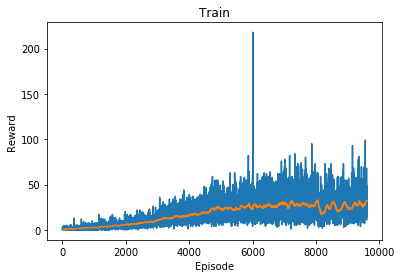

In [10]:
# количество эпизодов, которые играем
NUM_EPISODES = 100000

# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 5
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE=10000

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 50000

# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000

# Загрузка сохраненной модели
policy_net.load_state_dict(torch.load("my_model", map_location=device))
target_net.load_state_dict(policy_net.state_dict())
time = 600

policy_net.train()
target_net.eval()

state_holder = StateHolder()
test_rewards = []

# Общее число 
steps_done = 0

# Задание 3. Заполнить пропуски в нижеприведенном коде.

for e in tqdm.tqdm_notebook(range(NUM_EPISODES)):
    
    # Инициализации разлиxных переменных
    # env - среды
    # state_holder - хранителя состояния
    # lives - количества жизней в начале эпизода игры (Важно!)
    # ep_rewards - массив всех наград
    
    env.reset()
    state_holder.reset()
    lives = 5
    ep_rewards = []
    
    state = state_holder.get()
    for t in count():
        
        # Рассчет eps_threshold'а для e-greedy
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        # Шаг одного кадра игры
        action = select_action(state, eps_threshold)
        _, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        ep_rewards.append(reward)
        
        # где:
        # reward - награда, полученная в рамках последнего действия
        # done - флаг окончания эпизода
        # info - важная системная информация
        
        # Код обработки перехода
        # Работа с ReplayMemory
        state_holder.push(get_screen())
        
        # Задание 3.1. Необходимо дополниь код следующим трюком, который значительно
        # улучшает сходимость обучения. В случае, если эпизод не закончился, но агент на 
        # очередном шаге потерял жизнь, то такой переход надо класть в ReplayMemory как финальный.
        # При этом, необходимо далее продолжать эпизод игры, пока не получите done == True
        # Тет самым вы научите агента понимать, что терять жизни по дороге - плохо.
        
        if not done:
            if (info['ale.lives'] < lives):
                next_state = None
                lives = info['ale.lives']
            else:
                next_state = state_holder.get()
        else:
            next_state = None
        memory.push(state, action, next_state, reward)
        state = state_holder.get()
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            optimize_model()
        
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
               
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            # Суммарный reward(не дисконтированный) за последний эпизод
            print("Episode score : {}".format(train_rewards[-1]))
            # Средний reward по последним 100 эпизодам
            mean_reward = np.mean(train_rewards[-100:])
            print("Mean score : {}".format(mean_reward))

            plot_rewards()
            break 
    if (e % time) == 0:
        torch.save(policy_net.state_dict(), "my_model")
        if time != 100: time -= 100
        print("Model saved!")
    if (mean_reward > 35):
        print("Good enough!")
        break

In [14]:
with open('memory.pkl', "wb") as file:
    pickle.dump(memory, file)

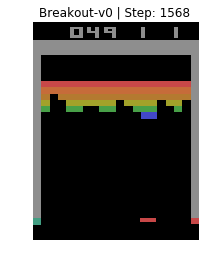

Total game reward : 49.0


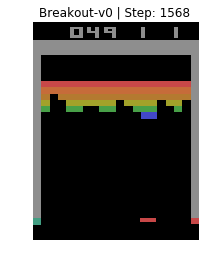

In [11]:
# Тут код для тестирования.
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента, насколько он хорош !?

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


policy_net.eval()
env.reset()
state_holder.reset()
    
state_holder.push(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))

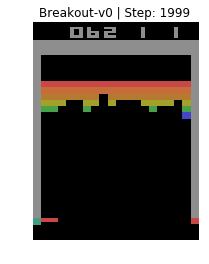

Total game reward : 62.0


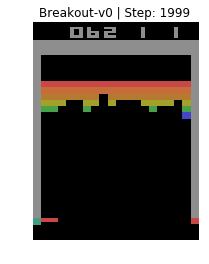

In [15]:
# Тут код для тестирования.
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента, насколько он хорош !?

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


policy_net.eval()
env.reset()
state_holder.reset()
    
state_holder.push(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))